In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xlwt
from xlwt import Workbook
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
mpl.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


In [2]:
# Read the image
im = Image.open(r"abc.jpeg")
width, height = im.size
l=80
t = 780
r = width
b = 900

img1 = cv2.imread("abc.jpeg",0)
img = img1[t:b, l:r]


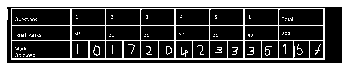

In [3]:
 # Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite("Image_bin.jpg",img_bin)
plt.axis('off')
plt.imshow(img_bin);

In [4]:
def f(x):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//x

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    plt.imshow(verticle_lines_img);
    plt.axis('off')

    plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')

interact(f,  x=widgets.IntSlider(min=1,max=255,step=1,value=50));


interactive(children=(IntSlider(value=50, description='x', max=255, min=1), Output()), _dom_classes=('widget-i…

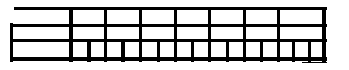

In [5]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(img_final_bin)

In [6]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="left-to-right")

140 76 31 32
178 76 28 32
213 76 31 32
251 76 30 32
288 76 32 32
327 76 28 32
362 76 30 32
399 76 29 32
435 76 31 32
473 76 29 32
509 76 30 32
546 76 29 32
582 76 26 32
614 76 27 32
648 115 24 2
648 76 24 32


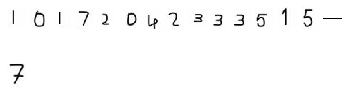

In [7]:
idx = 0
d = 0
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    #print(x,y,w,h)

    if (w < 65 and h < 65 and y < 130):
        idx += 1
        new_img = img[y:y+h, x:x+w]
        plt.subplot(4,15,idx)
        print(x,y,w,h)
        plt.imshow(new_img )
        #cv2.imwrite("Cropped/hello.png",new_img) 
        filename = "Cropped/file_%d.jpg"%d
        cv2.imwrite(filename, new_img)
        d+=1
        plt.axis('off')





c:\users\isra shafique\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


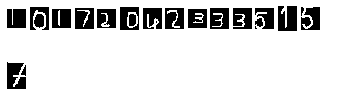

In [8]:
model = load_model('final_model.h5')

def load_images_from_folder(folder):
    images = []
    d = 0
    for c in contours:
        filename = "file_%d.jpg"%d
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        d+=1
    return images
images= load_images_from_folder('Cropped')
idx=0
d=0
for imgs in images:
    idx += 1
    img = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY +
                                 cv2.THRESH_OTSU)
    invert = cv2.bitwise_not(thresh1)  # OR
    row,col=invert.shape
    invert=invert[3:row-3,3:col-3]
    filename = "ready/file_%d.jpg"%d
    cv2.imwrite(filename, invert)
    plt.subplot(4,15,idx)
    plt.imshow(invert)
    d+=1
    plt.axis('off')



20 3
20 17
20 5
20 17
20 13
20 17
20 18
20 17
17 20
20 19
20 19
20 17
20 7
20 13
19 20


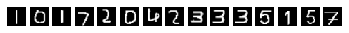

In [9]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
def change_img(filename,d,idx):
    img = cv2.cvtColor(filename, cv2.COLOR_BGR2GRAY)

    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY +
                                 cv2.THRESH_OTSU)
    invert = cv2.bitwise_not(thresh1)  # OR

    # De-allocate any associated memory usage

    gray = cv2.resize(255 - invert, (28, 28))

    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:, 0]) == 0:
        gray = np.delete(gray, 0, 1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:, -1]) == 0:
        gray = np.delete(gray, -1, 1)
    rows, cols = gray.shape
    
    if rows > cols:
        factor = 20.0 / rows
        rows = 20
        cols = int(round(cols * factor))
        gray = cv2.resize(gray, (cols, rows))
    else:
        factor = 20.0 / cols
        cols = 20
        rows = int(round(rows * factor))
        gray = cv2.resize(gray, (cols, rows))
    print(rows,cols)
    colsPadding = (int(np.math.ceil((28 - cols) / 2.0)), int(np.math.floor((28 - cols) / 2.0)))
    rowsPadding =(int(np.math.ceil((28 - rows) / 2.0)), int(np.math.floor((28 - rows) / 2.0)))
    gray = np.lib.pad(gray, (rowsPadding, colsPadding), 'constant')
    shiftx, shifty = getBestShift(gray)
    shifted = shift(gray, shiftx, shifty)
    gray = shifted  
    filename = "final/file_%d.jpg"%d
    cv2.imwrite(filename, gray)
    plt.subplot(4,15,idx)
    plt.imshow(gray)
    plt.axis('off')
images= load_images_from_folder('ready')
idx=0
d=0
for imgs in images:
    idx+=1
    change_img(imgs,d,idx)  
    d+=1


In [10]:
model = load_model('final_model.h5')

def load_image(filename):
    # load the image
    img = load_img(filename, color_mode = "grayscale", target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


def get_img():
    wb = Workbook()
    sheet1 = wb.add_sheet('Sheet 1')
    d = 0
    while d<15:
        filename = "file_%d.jpg"%d
        img = load_image('final/'+filename+'')
        digit = model.predict_classes(img)
        digit=int(digit)
        print(digit)
        sheet1.write(d, 0, digit) 
        d+=1
    wb.save('example.xls')
get_img()

   

1
0
1
7
2
0
4
2
3
3
3
5
1
5
7


PermissionError: [Errno 13] Permission denied: 'example.xls'